# Demonstration of Covariant Approximation Averaging (CAA) 

In [1]:
import statpy as sp
import numpy as np 
import matplotlib.pyplot as plt

## Read correlator data

We begin by using `statpy` to load correlator data from a single ensemble with ID `9a`. The data has been **blinded** using a multiplicative blinding factor to prevent psychological bias during the analysis.

In [2]:
filename = f"/Users/sebastian/Dev/data/correlator/9a/fermionic.db"
db = sp.database.core.DB(filename, num_proc=None, repo_path="/Users/sebastian/Dev/libs/statpy/src")

STATPY:		0.660549 s: Initialized database with statpy commit hash 9a85f3e02db7e31cddb410250b7c6a504cc724a6 and None processes.
STATPY:		0.660701 s: LOAD /Users/sebastian/Dev/data/correlator/9a/fermionic.db


### Inspection of database

Next, we inspect the entries stored in the database:

In [3]:
db.print()

STATPY:		1.426791 s: 

	Database consists of

	9a/exact_exact/G0_G0_ll
	9a/exact_sloppy/G0_G0_ll
	9a/sloppy_sloppy/G0_G0_ll
	9a/exact_exact/G1_G1_ll
	9a/exact_sloppy/G1_G1_ll
	9a/sloppy_sloppy/G1_G1_ll
	9a/exact_exact/G2_G2_ll
	9a/exact_sloppy/G2_G2_ll
	9a/sloppy_sloppy/G2_G2_ll
	9a/exact_exact/G5_G5_ll
	9a/exact_sloppy/G5_G5_ll
	9a/sloppy_sloppy/G5_G5_ll
	9a/exact_exact/G0_G0_lc
	9a/exact_sloppy/G0_G0_lc
	9a/sloppy_sloppy/G0_G0_lc
	9a/exact_exact/G1_G1_lc
	9a/exact_sloppy/G1_G1_lc
	9a/sloppy_sloppy/G1_G1_lc
	9a/exact_exact/G2_G2_lc
	9a/exact_sloppy/G2_G2_lc
	9a/sloppy_sloppy/G2_G2_lc



Each entry in the database is identified by a tag, composed of three parts:
1. Ensemble ID: here, always 9a
2. Solve type: indicates both the set of source positions and the numerical precision of the solve
3. Correlator type: specifies the quantum numbers used to construct the correlator from quark propagators

The **solve type** follows the pattern `X_Y`, where:
- The first label (`X`) refers to the set of source positions:
	- exact means a few source positions used for high-precision reference solves
	- sloppy refers to a different, larger set of source positions used for approximate solves
- The second label (`Y`) describes the numerical precision of the solve:
	- exact means a high-precision solution of the Dirac equation
	- sloppy means a reduced-precision (and thus faster) solve

In our specific case, we have the combinations:
- `exact_exact`: high-precision solve at the exact source position
- `exact_sloppy`: low-precision solve at the same exact source position (used to estimate bias)
- `sloppy_sloppy`: low-precision solves at different source positions (used for variance reduction)

### Leafs

Each object associated with a tag is called a `leaf`. A leaf contains both the **mean value** of the observable and its corresponding [**jackknife sample**](https://en.wikipedia.org/wiki/Jackknife_resampling). The jackknife ensemble enables robust estimation of statistical uncertainties (via `db.jackknife_variance()`). 

Thanks to this structure, `statpy` makes it easy to compute **derived quantities** and **propagate statistical uncertainties** in a consistent and automated way through the `db.combine()` method.

For purposes of data exploration and preparation, it can be useful to retain the original measurement samples — as we do in this notebook. Samples can be combined using the `db.combine_sample()` method. 

We can now inspect the leafs in the database:

In [4]:
db.database[f"9a/exact_exact/G0_G0_lc"]

In [5]:
print(db.database["9a/exact_exact/G0_G0_lc"].mean.shape)
print(db.database["9a/sloppy_sloppy/G0_G0_lc"].mean.shape)

(1, 64)
(8, 64)


Each row in the mean array corresponds to a different source position. In this case, the `exact_exact` tag includes a single source position, while the `sloppy_sloppy` tag includes eight source positions, reflecting the denser sampling used in the sloppy solves.

# Data preparation
For the current analysis, we are not interested in the `G5_G5_ll` leafs, which correspond to the [pion](https://de.wikipedia.org/wiki/Pion). To remove them from the database, we can do the following:

In [6]:
pion_tags = db.get_tags("G5_G5_ll")
print(pion_tags)
db.remove_leaf(*pion_tags)

# reprint db content
db.print()

['9a/exact_exact/G5_G5_ll', '9a/exact_sloppy/G5_G5_ll', '9a/sloppy_sloppy/G5_G5_ll']
STATPY:		1.441482 s: remove 9a/exact_exact/G5_G5_ll.
STATPY:		1.441549 s: remove 9a/exact_sloppy/G5_G5_ll.
STATPY:		1.441604 s: remove 9a/sloppy_sloppy/G5_G5_ll.
STATPY:		1.442192 s: 

	Database consists of

	9a/exact_exact/G0_G0_ll
	9a/exact_sloppy/G0_G0_ll
	9a/sloppy_sloppy/G0_G0_ll
	9a/exact_exact/G1_G1_ll
	9a/exact_sloppy/G1_G1_ll
	9a/sloppy_sloppy/G1_G1_ll
	9a/exact_exact/G2_G2_ll
	9a/exact_sloppy/G2_G2_ll
	9a/sloppy_sloppy/G2_G2_ll
	9a/exact_exact/G0_G0_lc
	9a/exact_sloppy/G0_G0_lc
	9a/sloppy_sloppy/G0_G0_lc
	9a/exact_exact/G1_G1_lc
	9a/exact_sloppy/G1_G1_lc
	9a/sloppy_sloppy/G1_G1_lc
	9a/exact_exact/G2_G2_lc
	9a/exact_sloppy/G2_G2_lc
	9a/sloppy_sloppy/G2_G2_lc



After removing the pion correlators, the remaining database entries are vector correlators of two types: `ll` (local-local) and `lc` (local-conserved). Both represent the same physical quantity but differ in how they are implemented on the lattice.

The `lc` version more closely resembles the structure of the continuum theory and has better symmetry properties, but it is also more expensive to compute. In contrast, the `ll` version is computationally cheaper but less faithful to continuum behavior.

Each of these vector correlators comes in three variants: `G0`, `G1`, and `G2`, corresponding to the three spatial directions. Due to the lattice’s rotational symmetry, these directions are physically equivalent. We can therefore average over them (separately for the ll and lc types) to reduce statistical noise and improve signal quality without losing physical information.

## Improved estimate
As described in the [README.md](https://github.com/spieseba/correlatorCAA/blob/main/README.md), we construct the **improved estimator** as:
$$
  O^\text{(imp)} = O^\text{(rest)} + O_G^\text{(appx)},
$$
where:
- $O^\text{(rest)} = O - O^\text{(appx)}$ is a bias correction
- $O_G^\text{(appx)} = \frac{1}{N_G} \sum_{g \in G} O^{\text{(appx)},g}$ is an average over $N_G$ symmetry transformations.

In this analysis, the `sloppy_sloppy` entires are used to estimate $O_G^\text{(appx)}$. For the `ll` correlator, we average over 128 source positions, while for the `lc` correlator, only 8 source positions are available:

In [7]:
print(f"ll sloppy_sloppy source positions: {db.database["9a/sloppy_sloppy/G0_G0_ll"].mean.shape[0]}")
print(f"lc sloppy_sloppy source positions: {db.database["9a/sloppy_sloppy/G0_G0_lc"].mean.shape[0]}")

ll sloppy_sloppy source positions: 128
lc sloppy_sloppy source positions: 8


The exact estimator $O$ is constructed from the exact_exact data, while its approximation $O^{(\text{appx})}$ is taken from the corresponding exact_sloppy data. Both are computed at the same single source position on each configuration to ensure strong correlations, which are crucial for reducing the variance of the bias correction term $O^{(\text{rest})}$:

In [8]:
print(f"ll exact_exact source positions: {db.database["9a/exact_sloppy/G0_G0_ll"].mean.shape[0]}")
print(f"ll exact_sloppy source positions: {db.database["9a/exact_sloppy/G0_G0_ll"].mean.shape[0]}")

ll exact_exact source positions: 1
ll exact_sloppy source positions: 1


In the context of [arXiv 2410.17053](https://inspirehep.net/literature/2841842), we are particularly interested in constructing improved estimators for:
- the `ll` correlator $C^{(\text{ll})}$
- the `lc` correlator $C^{(\text{lc})}$, and
- their ratio, defined as $Z(t) = C^{(\text{lc})}/C^{(\text{ll})}$.

### Source averaging

When analyzing the `ll` and `lc` correlators individually, the improved approximation term $O_G^{(\text{appx})}$ can be constructed by averaging over all available sloppy_sloppy source positions.

However, for the ratio $Z(t)$, it is beneficial to restrict the averaging to the common source positions used in both `ll` and `lc` estimates. This ensures that the numerator and denominator are highly correlated, which leads to partial cancellation of fluctuations in the ratio’s statistical error.

This is captured by the standard variance propagation formula:
$$
    \sigma_f^2 \approx f^2 \left[\left(\frac{\sigma_A}{A}\right)^2 + \left(\frac{\sigma_B}{B}\right)^2 - 2\frac{\sigma_{AB}}{AB} \right], \quad \text{where } f = \frac{A}{B}.
$$
The last term accounts for the covariance between numerator and denominator. When A and B are strongly correlated, this term significantly reduces the overall variance, leading to a more precise estimate of $Z(t)$. 

In our case, the set of source positions used for the `lc` correlator is a subset of those used for the `ll` correlator. To exploit the correlation between numerator and denominator in the ratio $Z(t)$, we construct three separate improved estimators:
1. A full source average for the `ll` correlator over all available sloppy_sloppy source positions.
2. A full source average for the `lc` correlator over its (fewer) available source positions.
3. An additional `ll` source average, restricted to the same source positions used for the `lc` correlator, to serve as a matched denominator in the ratio $Z(t)$.

In the following code blocks, we perform this source-matched averaging and remove the original, unaveraged data from the database to keep the dataset clean and focused.

In [9]:
for i in range(3):
    src_tag_lc = f"9a/sloppy_sloppy/G{i}_G{i}_lc"
    src_tag_ll = f"9a/sloppy_sloppy/G{i}_G{i}_ll"
    matched_sample = {} 
    for cfg in db.get_cfgs(src_tag_lc):
        matched_idxs = [i for i,pt in enumerate(db.database[src_tag_ll].misc["ptsrcs"][cfg]) if pt in db.database[src_tag_lc].misc["ptsrcs"][cfg]]
        matched_sample[cfg] = np.mean(db.database[src_tag_ll].sample[cfg][matched_idxs], axis=0).real
    db.add_leaf(f"9a/sloppy_sloppy/G{i}_G{i}_ll/matched", mean=None, jks=None, sample=matched_sample, misc=None)

In [10]:
for i in range(3):
    for ctype in ["ll", "lc"]:
        for dataset in ["exact_exact", "exact_sloppy", "sloppy_sloppy"]:
            tag = f"9a/{dataset}/G{i}_G{i}_{ctype}"
            avg_sample = db.combine_sample(tag, f=lambda x: np.mean(x, axis=0).real)
            db.remove_leaf(tag, verbosity=-1)
            db.add_leaf(tag, mean=None, jks=None, sample=avg_sample, misc=None)

In [11]:
db.print()

STATPY:		1.496416 s: 

	Database consists of

	9a/sloppy_sloppy/G0_G0_ll/matched
	9a/sloppy_sloppy/G1_G1_ll/matched
	9a/sloppy_sloppy/G2_G2_ll/matched
	9a/exact_exact/G0_G0_ll
	9a/exact_sloppy/G0_G0_ll
	9a/sloppy_sloppy/G0_G0_ll
	9a/exact_exact/G0_G0_lc
	9a/exact_sloppy/G0_G0_lc
	9a/sloppy_sloppy/G0_G0_lc
	9a/exact_exact/G1_G1_ll
	9a/exact_sloppy/G1_G1_ll
	9a/sloppy_sloppy/G1_G1_ll
	9a/exact_exact/G1_G1_lc
	9a/exact_sloppy/G1_G1_lc
	9a/sloppy_sloppy/G1_G1_lc
	9a/exact_exact/G2_G2_ll
	9a/exact_sloppy/G2_G2_ll
	9a/sloppy_sloppy/G2_G2_ll
	9a/exact_exact/G2_G2_lc
	9a/exact_sloppy/G2_G2_lc
	9a/sloppy_sloppy/G2_G2_lc



### Spatial index averaging
As discussed above, we exploit the rotational symmetry of the lattice to average the correlators over the spatial directions. We again remove the original, unaveraged correlators associated with individual spatial indices:

In [12]:
def average_i(tags):
    db.combine_sample(*tags, f=lambda *x: np.mean(x, axis=0).real, dst_tag=tags[0].replace("G0_G0", "Gi_Gi"))
    for tag in tags:
        db.remove_leaf(tag, verbosity=-1)

In [13]:
for dataset in ["exact_exact", "exact_sloppy", "sloppy_sloppy"]:
    for ctype in ["ll", "lc"]:
        average_i([f"9a/{dataset}/G{i}_G{i}_{ctype}" for i in range(3)])
        if dataset == "sloppy_sloppy" and ctype == "ll":
            average_i([f"9a/{dataset}/G{i}_G{i}_{ctype}/matched" for i in range(3)])

In [14]:
db.print()

STATPY:		1.518254 s: 

	Database consists of

	9a/exact_exact/Gi_Gi_ll
	9a/exact_exact/Gi_Gi_lc
	9a/exact_sloppy/Gi_Gi_ll
	9a/exact_sloppy/Gi_Gi_lc
	9a/sloppy_sloppy/Gi_Gi_ll
	9a/sloppy_sloppy/Gi_Gi_ll/matched
	9a/sloppy_sloppy/Gi_Gi_lc



# Data exploration and checks
Before applying CAA to the correlator data, we first explore and validate the dataset. This includes basic sanity checks and visualizations to ensure the data is well-behaved and suitable for further analysis.

### Thermalization
We begin by verifying that the correlator data, generated through a Markov Chain Monte Carlo (MCMC) simulation, are thermalized, i.e., the Markov chain has reached equilibrium and samples the correct target distribution. As a simple check, we plot the correlator values at selected time slices against the Monte Carlo time $t_\text{MC}$.

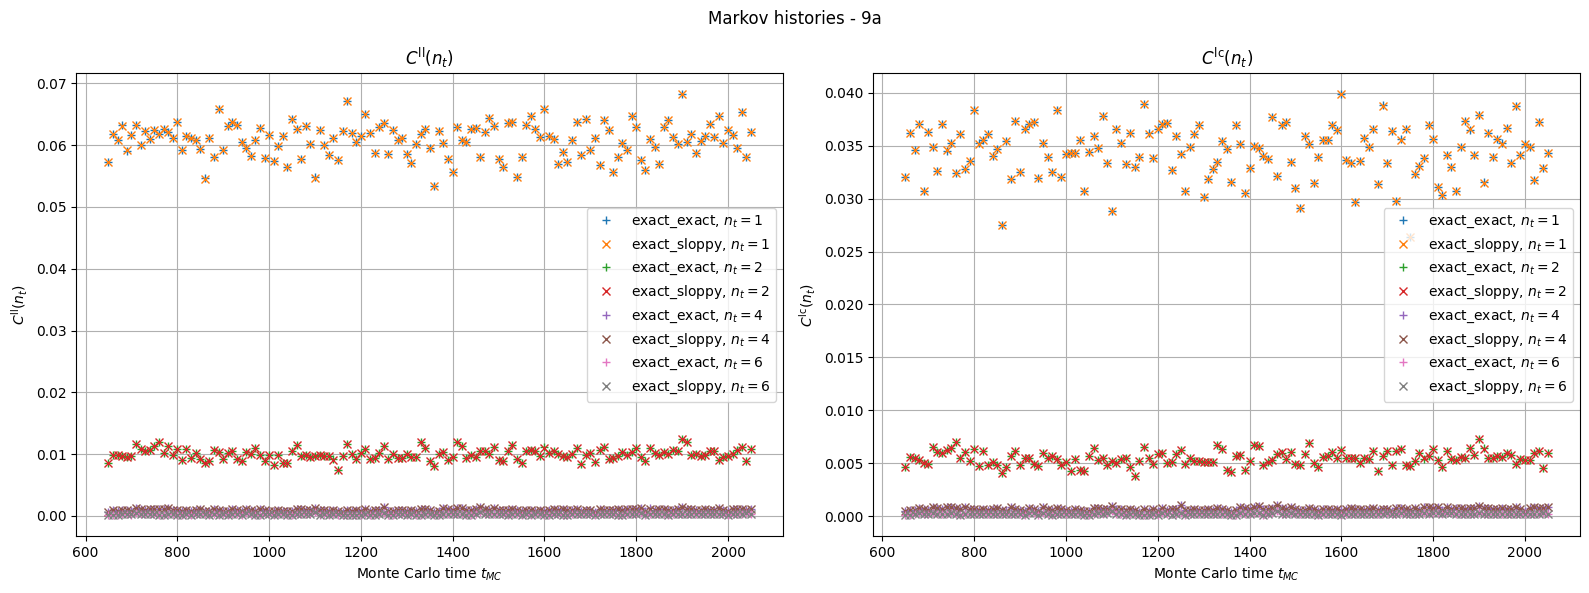

In [15]:
def check_thermalization(ensemble_label):
    
    cfg_idxs = [int(cfg.split("-")[-1]) for cfg in db.database[f"{ensemble_label}/exact_exact/Gi_Gi_ll"].sample.keys()]
    
    Gi_Gi_ll_sloppy = db.as_array(db.database[f"{ensemble_label}/exact_sloppy/Gi_Gi_ll"].sample)
    Gi_Gi_lc_sloppy = db.as_array(db.database[f"{ensemble_label}/exact_sloppy/Gi_Gi_lc"].sample)       
    Gi_Gi_ll_exact =  db.as_array(db.database[f"{ensemble_label}/exact_exact/Gi_Gi_ll"].sample)
    Gi_Gi_lc_exact =  db.as_array(db.database[f"{ensemble_label}/exact_exact/Gi_Gi_lc"].sample)   
    
    fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16,6))
    
    ax0.set_title(r"$C^\text{ll}(n_t)$")
    ax0.set_xlabel(r"Monte Carlo time $t_{MC}$")
    ax0.set_ylabel(r"$C^\text{ll}(n_t)$")
    for t in [1,2,4,6]:
        ax0.plot(cfg_idxs, Gi_Gi_ll_exact[:,t].real, marker="+", ls="", label=r"exact_exact, $n_t=$" + f"{t}")
        ax0.plot(cfg_idxs, Gi_Gi_ll_sloppy[:,t].real, marker="x", ls="", label=r"exact_sloppy, $n_t=$" + f"{t}")
    ax0.legend(loc="center right")
    ax0.grid()
    
    ax1.set_title(r"$C^\text{lc}(n_t)$")
    ax1.set_xlabel(r"Monte Carlo time $t_{MC}$")
    ax1.set_ylabel(r"$C^\text{lc}(n_t)$")
    for t in [1,2,4,6]:
        ax1.plot(cfg_idxs, Gi_Gi_lc_exact[:,t].real, marker="+", ls="", label=r"exact_exact, $n_t=$" + f"{t}")
        ax1.plot(cfg_idxs, Gi_Gi_lc_sloppy[:,t].real, marker="x", ls="", label=r"exact_sloppy, $n_t=$" + f"{t}")
    ax1.legend(loc="center right")
    ax1.grid()
    
    plt.suptitle(f"Markov histories - {ensemble_label}")
    plt.tight_layout()
    plt.plot()

check_thermalization("9a")

Since the data fluctuates around a stable mean without exhibiting visible trends or drifts, we conclude that the observables are thermalized over the given Monte Carlo time range.

### Treating autocorrelations

Since the correlator data originate from a Markov Chain Monte Carlo (MCMC) simulation, it is essential to check for autocorrelations between successive configurations. Autocorrelations can artificially reduce the estimated statistical error if not properly accounted for. To assess this, we performed a binning study for an exemplary time slice ($n_t = 3$) and found that the variance remains stable across increasing bin sizes. This indicates that autocorrelations are negligible in our dataset, and we can proceed with the analysis using the raw, unbinned samples.

In [16]:
def Gi_Gi_binning_study(tag, nt, binsizes=[1,2,4,8]):
    var = db.binning_study(tag, binsizes)
    sp.message(f"Delayed binning study of {tag} (nt = {nt}): var (binsizes={binsizes}): \n\t\t\t\t{[float(var[b][nt]**.5) for b in binsizes]}")

sp.message(f"--------------------- Binning study for ensemble 9a --------------------")
for dataset in ["exact_exact", "exact_sloppy", "sloppy_sloppy"]:
    for ctype in ["ll", "lc"]:
        sp.message(f"--- {dataset} - {ctype} ---")
        Gi_Gi_binning_study(f"9a/{dataset}/Gi_Gi_{ctype}", 3, [1,2,4,8])
sp.message("-------------------------------------------------------\n")

STATPY:		1.834775 s: --------------------- Binning study for ensemble 9a --------------------
STATPY:		1.834861 s: --- exact_exact - ll ---
STATPY:		1.835071 s: Delayed binning study with unbinned sample size(s): {np.str_('9a'): 141} (number of unique cfgs: 141)
STATPY:		1.849573 s: Delayed binning study of 9a/exact_exact/Gi_Gi_ll (nt = 3): var (binsizes=[1, 2, 4, 8]): 
				[2.599952832001261e-05, 2.8919023071851808e-05, 3.116386025586951e-05, 3.534273046671894e-05]
STATPY:		1.849594 s: --- exact_exact - lc ---
STATPY:		1.849655 s: Delayed binning study with unbinned sample size(s): {np.str_('9a'): 141} (number of unique cfgs: 141)
STATPY:		1.863522 s: Delayed binning study of 9a/exact_exact/Gi_Gi_lc (nt = 3): var (binsizes=[1, 2, 4, 8]): 
				[1.8389426446823065e-05, 2.0145634591155938e-05, 2.1246657474473237e-05, 2.4829382256530447e-05]
STATPY:		1.863545 s: --- exact_sloppy - ll ---
STATPY:		1.863609 s: Delayed binning study with unbinned sample size(s): {np.str_('9a'): 141} (number 

### Correlator consistency
Next, we compare the correlator means for different solve types (`exact_exact`, `exact_sloppy`, `sloppy_sloppy`) to ensure that the sloppy solves are reliable approximations of the exact ones.

To do this, we analyze the dimensionless combination $t^3 C^\text{lc}(t)$, which helps highlight deviations in the correlator behavior across time slices. This form is often used in studies of the hadronic vacuum polarization contribution to the muon $g\!-\!2$, as it emphasizes the region most relevant to the physical observable. Here. it simply serves as a useful diagnostic tool.

[]

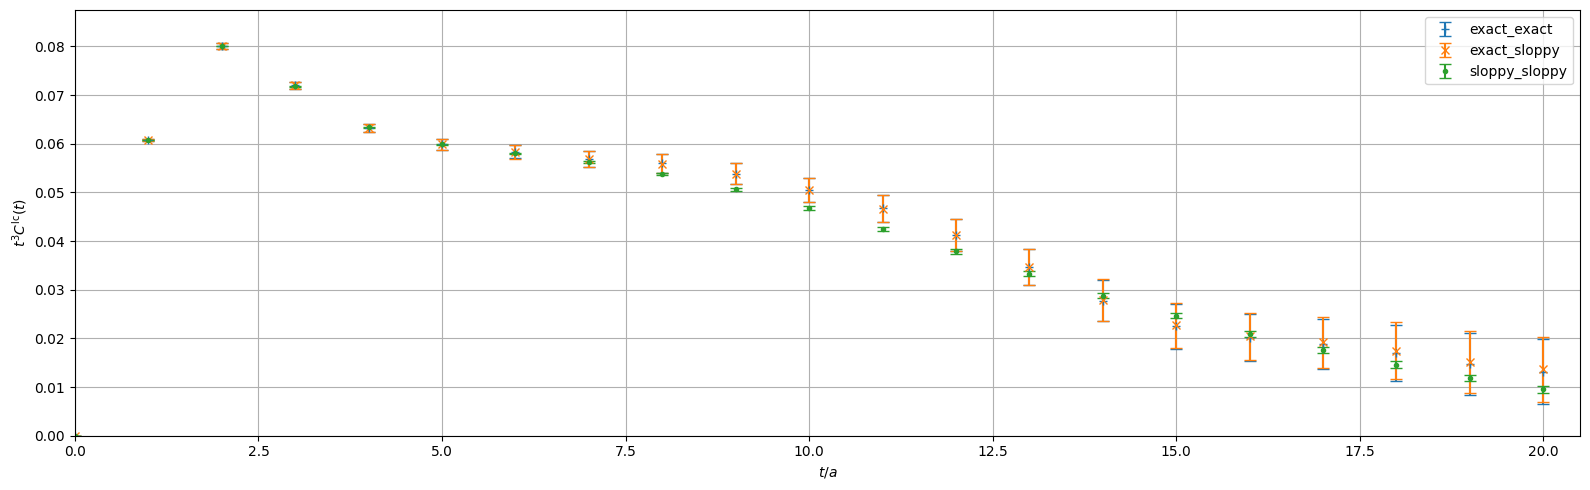

In [17]:
def add_solve_type_to_plot(ax, solve_type, ctype="ll", ensemble="9a"):
    Gi_Gi = db.database[f"{ensemble}/{solve_type}/Gi_Gi_{ctype}"].mean
    ts = np.arange(len(Gi_Gi))
    Gi_Gi_var = db.jackknife_variance(f"{ensemble}/{solve_type}/Gi_Gi_{ctype}", binsize=1)
    m = {"exact_exact": "+", "exact_sloppy": "x", "sloppy_sloppy": "."}[solve_type]
    ax.errorbar(ts, Gi_Gi * ts**3, Gi_Gi_var**.5 * ts**3, marker=m, capsize=4, linestyle="", label=solve_type)


fig, ax = plt.subplots(figsize=(16,5))

add_solve_type_to_plot(ax, "exact_exact")
add_solve_type_to_plot(ax, "exact_sloppy")
add_solve_type_to_plot(ax, "sloppy_sloppy")

ax.set_ylabel(r"$t^3 C^\text{lc}(t)$")
ax.set_xlabel(r"$t/a$")
ax.set_xlim(0.0,20.5)
ax.set_ylim(0.0, 0.0875)
ax.legend()
ax.grid()

plt.tight_layout()
plt.plot()

We observe that `exact_exact` and `exact_sloppy` correlators align very well across all time slices, with comparable statistical errors. This confirms that sloppy solves provide a high-quality approximation when computed at the same source positions as the exact solves.

In contrast, the sloppy_sloppy correlator agrees with the exact_sloppy result only within statistical margins. A mild tension is visible in the range $t = 8\text{–}11$, likely a statistical fluctuation specific to this dataset. This discrepancy may be due to averaging over different source positions, which can introduce additional variance in certain time regions.

The statistical errors for `sloppy_sloppy` are significantly smaller (reduced by roughly a factor of $\sim \sqrt{8}$) due to averaging over eight source positions instead of just one.

## Application of CAA
Let us now apply CAA. For this, we define a helper function that allows us to specify the tags for $O$, $O^\text{(appx)}$, and $O^\text{(appx)}_G$ from which the improved estimator:
$$
    O^\text{(imp)} = O^\text{(rest)} + O_G^\text{(appx)}, \quad\text{with } O^\text{(rest)} = O - O^\text{(appx)} 
$$
is computed.

In [18]:
def apply_CAA(tag, appx_tag, appx_G_tag, CAA_label="CAA"):
    CAA_tag = f"{tag.split("/")[0]}/{CAA_label}/{tag.split("/")[-1]}"
    db.combine(tag, appx_tag, f=lambda O,O_appx: O - O_appx, dst_tag=f"{CAA_tag}_rest") 
    db.combine(f"{CAA_tag}_rest", appx_G_tag, f=lambda O_rest,O_appx_G: O_rest + O_appx_G, dst_tag=CAA_tag)

### $C^\text{(ll)}$

We start with the improved estimator for $C^\text{(ll)}$. As mentioned above, we use the `exact_exact` $C^\text{(ll)}$ data for $O$, the `exact_sloppy` $C^\text{(ll)}$ data for $O^\text{appx}$, and `sloppy_sloppy` $C^\text{(ll)}$ data for $O_G^\text{appx}$:

In [19]:
apply_CAA("9a/exact_exact/Gi_Gi_ll", "9a/exact_sloppy/Gi_Gi_ll", "9a/sloppy_sloppy/Gi_Gi_ll")

We can now compare the statistical errors of the improved estimate with the `exact_exact` and `sloppy_sloppy` estimates:

In [20]:
print((db.jackknife_variance("9a/exact_exact/Gi_Gi_ll", binsize=1) / db.jackknife_variance("9a/CAA/Gi_Gi_ll", binsize=1))**.5)

[12.16892166 12.67269178 11.78043973 11.01374092 11.53398993 10.94126697
 10.11377689  8.68032618  7.99211064  7.2662358   6.78692932  6.4864522
  6.60784901  6.83728677  7.12965321  7.24718297  7.17409325  7.4829042
  8.02554394  8.69110993  8.98766922  9.03424565  8.99695371  8.96999272
  8.84994774  8.75370823  8.97709533  8.73592805  8.33757742  7.88119616
  7.52444738  7.47018625  7.53836982  7.37313376  7.26176828  6.97430833
  6.95854918  7.15786853  7.4034971   7.90141594  8.64567733  8.76398035
  8.42458886  7.88952864  7.67133432  7.7335049   7.61492457  7.32537652
  7.32298647  7.24204288  7.26019615  6.73389431  6.57051864  7.08699469
  8.25839323  8.95158864  8.94508465  8.83689049  9.02850648  9.04527648
  8.8715841   9.8923003  11.59150772 11.11258598]


In [21]:
print((db.jackknife_variance("9a/sloppy_sloppy/Gi_Gi_ll", binsize=1) / db.jackknife_variance("9a/CAA/Gi_Gi_ll", binsize=1))**.5)

[0.99902786 1.00229216 1.00486376 1.00378075 0.98468896 0.95972247
 0.94989489 0.93906878 0.92392892 0.91033831 0.89840936 0.89584711
 0.89786459 0.89445279 0.88827351 0.89836698 0.91310516 0.92732204
 0.93711958 0.93638177 0.94014036 0.95248152 0.95453528 0.953338
 0.95722668 0.95570686 0.96286377 0.97238049 0.98136537 0.98760476
 0.97921617 0.9617327  0.95178995 0.94328698 0.92587685 0.90447172
 0.89646805 0.88849915 0.90524127 0.92633907 0.94793619 0.94154319
 0.91260192 0.86600767 0.82655991 0.81969036 0.82953455 0.85436649
 0.86819031 0.86979781 0.86913911 0.86972218 0.88007632 0.89624803
 0.89624536 0.89133761 0.90620616 0.92195373 0.94283745 0.94826664
 0.96188029 0.98061766 0.99476039 1.00198761]


As expected, the error of the improved estimate is roughly reduced to the same order of magnitude as for the `sloppy_sloppy` data, which can also be verified visually:

[]

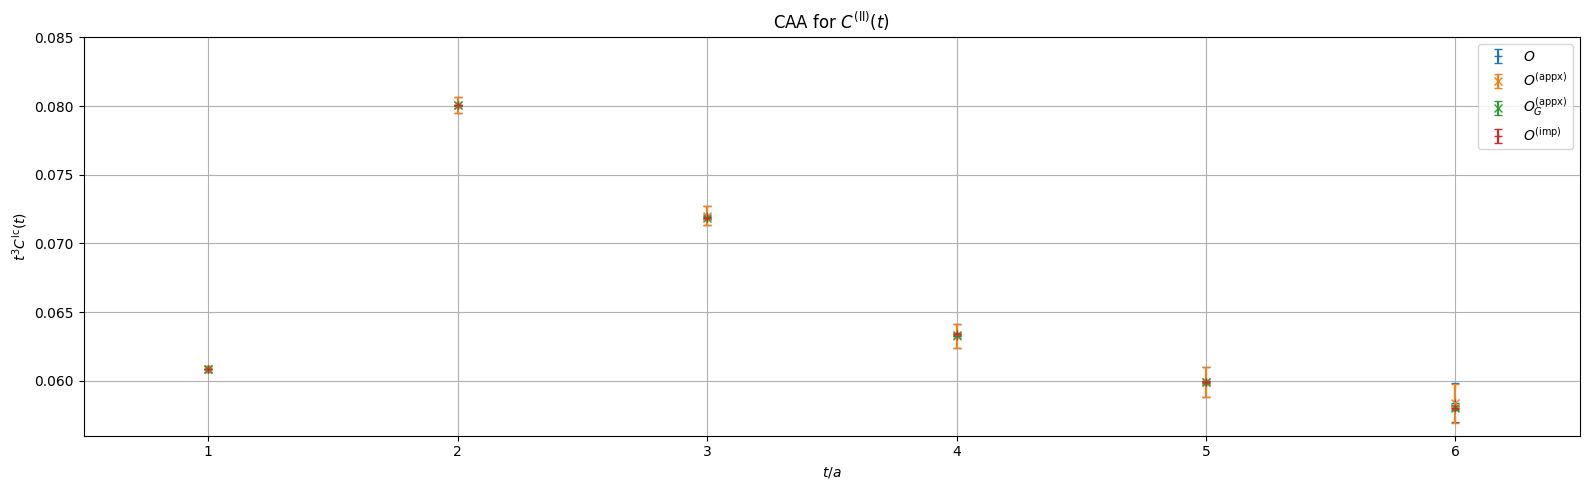

In [22]:
def add_CAA_to_plot(ax, tag, appx_tag, appx_G_tag, CAA_tag):
    O = db.database[tag].mean; O_var = db.jackknife_variance(tag, binsize=1)
    O_appx = db.database[appx_tag].mean; O_appx_var = db.jackknife_variance(appx_tag, binsize=1)
    O_G_appx = db.database[appx_G_tag].mean; O_G_appx_var = db.jackknife_variance(appx_G_tag, binsize=1)
    O_CAA = db.database[CAA_tag].mean; O_CAA_var = db.jackknife_variance(CAA_tag, binsize=1)

    ts = np.arange(len(O))

    ax.errorbar(ts, ts**3 * O, ts**3 * O_var**.5, marker="+", capsize=3, linestyle="", label=r"$O$")
    ax.errorbar(ts, ts**3 * O_appx, ts**3 * O_appx_var**.5, marker="x", capsize=3, linestyle="", label=r"$O^\text{(appx)}$")
    ax.errorbar(ts, ts**3 * O_G_appx, ts**3 * O_G_appx_var**.5, marker="x", capsize=3, linestyle="", label=r"$O^\text{(appx)}_G$")
    ax.errorbar(ts, ts**3 * O_CAA, ts**3 * O_CAA_var**.5, marker="+", capsize=3, linestyle="", label=r"$O^\text{(imp)}$")

    ax.set_ylabel(r"$t^3 C^\text{lc}(t)$")
    ax.set_xlabel(r"$t/a$")


fig, ax = plt.subplots(ncols=1, figsize=(16,5))

add_CAA_to_plot(ax, tag="9a/exact_exact/Gi_Gi_ll", appx_tag="9a/exact_sloppy/Gi_Gi_ll", appx_G_tag="9a/sloppy_sloppy/Gi_Gi_ll", CAA_tag="9a/CAA/Gi_Gi_ll")

ax.set_xlim(0.5,6.5)
ax.set_ylim(0.056, 0.085)

ax.set_title(r"CAA for $C^\text{(ll)}(t)$")
ax.grid()
ax.legend()

plt.tight_layout()
plt.plot()

### $C^\text{(lc)}$
Analogous to the `ll` case, we could directly use the `sloppy` solves of the `lc` correlator to construct an improved estimator. However, since `ll` and `lc` correlators describe the same physical quantity (up to discretization effects) and are highly correlated, we can alternatively treat the `ll` correlator as a cheap proxy for `lc` and use it to build an improved sloppy estimate for $C^{\text{(lc)}}$. To estimate the bias, we use matched source positions between `ll` and `lc`, ensuring high correlation between the observables.

Once we have this improved sloppy estimator, we use it to construct a CAA-improved version of the exact $C^{\text{(lc)}}$ correlator:

In [23]:
apply_CAA(tag="9a/sloppy_sloppy/Gi_Gi_lc", appx_tag=f"9a/sloppy_sloppy/Gi_Gi_ll/matched", appx_G_tag=f"9a/sloppy_sloppy/Gi_Gi_ll", CAA_label="CAA_sloppy")
apply_CAA(tag="9a/exact_exact/Gi_Gi_lc", appx_tag=f"9a/exact_sloppy/Gi_Gi_lc", appx_G_tag=f"9a/CAA_sloppy/Gi_Gi_lc", CAA_label="CAA")

Let us compare the statistical errors of the improved estimate with the `exact_exact` `lc` and `sloppy_sloppy` `ll` estimates:

In [24]:
print((db.jackknife_variance("9a/exact_exact/Gi_Gi_lc", binsize=1) / db.jackknife_variance("9a/CAA/Gi_Gi_lc", binsize=1))**.5)

[2.00416622 4.11430893 5.28082984 6.15545393 7.03224468 6.39626798
 5.87331109 5.22158368 4.80750533 4.34356192 4.24332569 4.1809089
 4.26057522 4.42262535 4.50257853 4.47650746 4.36384748 4.57502851
 5.02227487 5.47238436 5.63646689 5.75589779 5.78724045 5.83151667
 5.84466637 5.87606629 6.03386674 5.82687872 5.54963971 5.18469969
 4.90641263 4.76180621 4.80578006 4.85747759 4.88416933 4.94631637
 5.01313357 5.26538255 5.40284784 5.46839539 5.84574625 5.82640184
 5.51826994 5.04854724 4.94476697 5.16146114 5.29310279 5.11096841
 5.16891275 4.98905409 4.92135164 4.59940145 4.64774163 4.9644874
 5.96127828 6.32192364 6.05539521 5.70506579 5.69604187 5.58436476
 5.16909916 4.99433651 4.74152972 3.49890815]


In [25]:
print((db.jackknife_variance("9a/sloppy_sloppy/Gi_Gi_ll", binsize=1) / db.jackknife_variance("9a/CAA/Gi_Gi_lc", binsize=1))**.5)

[0.09887658 0.3580461  0.61206745 0.79316105 0.81592235 0.758694
 0.73928959 0.76506408 0.74935502 0.73297256 0.75101198 0.76945054
 0.78015889 0.77791319 0.75482853 0.7429282  0.74764306 0.7634683
 0.78668388 0.79098606 0.79283791 0.81482707 0.81918126 0.83428272
 0.84926171 0.86381965 0.86453507 0.87022111 0.88167283 0.87081673
 0.8589853  0.82424776 0.8106744  0.83062399 0.83382477 0.85963585
 0.87008291 0.87722222 0.8849089  0.86370568 0.85827907 0.84094263
 0.79933023 0.74547308 0.71582306 0.73325335 0.77237088 0.79953325
 0.81917745 0.80597479 0.79402851 0.80689136 0.83595471 0.84897001
 0.86320753 0.8521743  0.82896554 0.80204524 0.80282372 0.79313721
 0.77330215 0.69081856 0.57069889 0.34910067]


The statistical error of the improved estimator is within 20% of that of the `sloppy_sloppy` `ll` data. 

Additionally, we compare to a naive CAA estimate that does not incorporate the `ll` correlator data:

In [26]:
apply_CAA(tag="9a/exact_exact/Gi_Gi_lc", appx_tag=f"9a/exact_sloppy/Gi_Gi_lc", appx_G_tag=f"9a/sloppy_sloppy/Gi_Gi_lc", CAA_label="CAA_naive")
print((db.jackknife_variance("9a/CAA/Gi_Gi_lc", binsize=1) / db.jackknife_variance("9a/CAA_naive/Gi_Gi_lc", binsize=1))**.5)

[1.28814377 0.76531215 0.574777   0.39670969 0.36077726 0.37774781
 0.3838704  0.36723662 0.37017091 0.3963962  0.41768532 0.42471704
 0.43180111 0.44650386 0.46362251 0.48464077 0.48812475 0.47963208
 0.46187691 0.46245568 0.46329413 0.43582622 0.42145207 0.40801564
 0.40887413 0.41028236 0.42065987 0.41455206 0.40636807 0.42110781
 0.41880339 0.4228644  0.42196002 0.43451852 0.44886873 0.44737306
 0.46562255 0.48191059 0.47499203 0.46970037 0.45744001 0.47736711
 0.49678325 0.51529919 0.52887934 0.51258817 0.48478777 0.48330037
 0.48407828 0.47944187 0.48252514 0.48161608 0.47398714 0.47996001
 0.46163129 0.44863951 0.42638189 0.4084459  0.39282072 0.4078831
 0.43449251 0.50510093 0.62861598 0.66376048]


Thus, employing a two-stage approach, where the sloppy `lc` data are first improved using the `ll` correlator, yields a roughly twofold reduction in statistical error across most time slices, compared to using the `lc` data alone.

[]

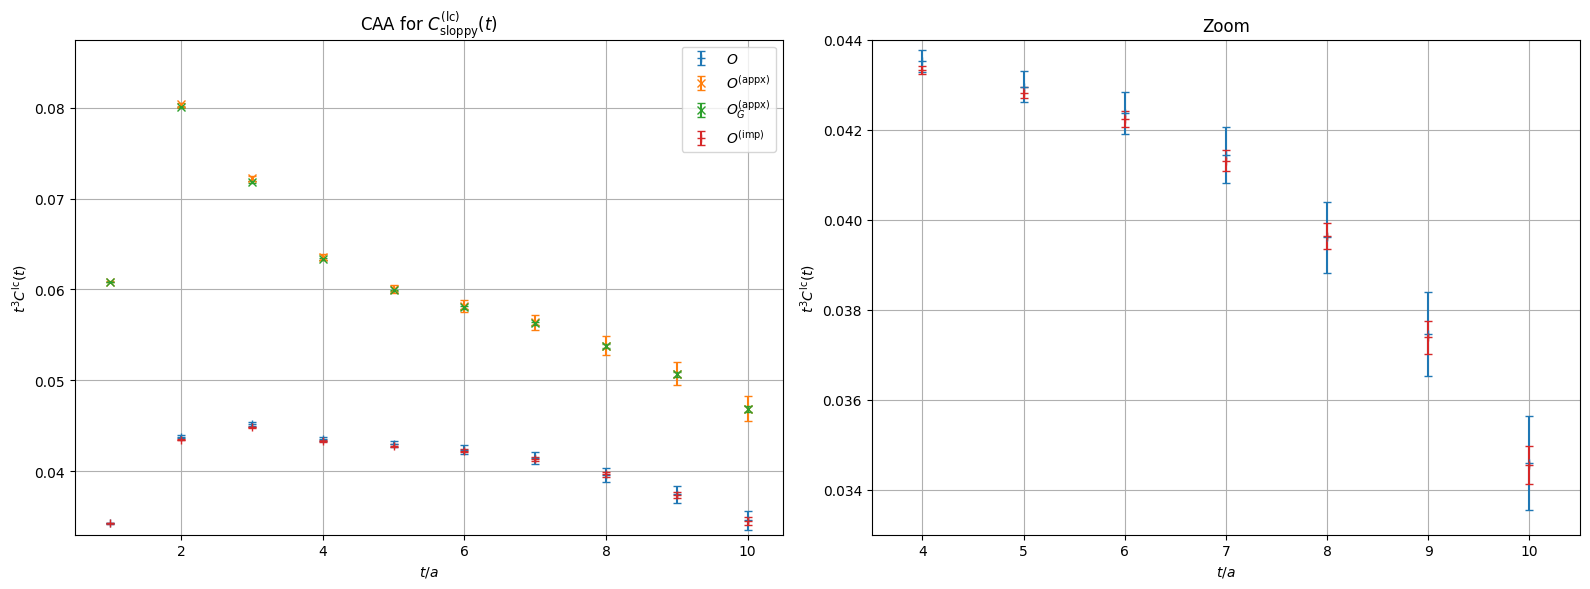

In [27]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16,6))

add_CAA_to_plot(ax0, tag="9a/sloppy_sloppy/Gi_Gi_lc", appx_tag=f"9a/sloppy_sloppy/Gi_Gi_ll/matched", appx_G_tag=f"9a/sloppy_sloppy/Gi_Gi_ll", CAA_tag="9a/CAA_sloppy/Gi_Gi_lc")
ax0.set_xlim(0.5,10.5)
ax0.set_ylim(0.033, 0.0875)
ax0.set_title(r"CAA for $C^\text{(lc)}_\text{sloppy}(t)$")
ax0.grid()
ax0.legend()

add_CAA_to_plot(ax1, tag="9a/sloppy_sloppy/Gi_Gi_lc", appx_tag=f"9a/sloppy_sloppy/Gi_Gi_ll/matched", appx_G_tag=f"9a/sloppy_sloppy/Gi_Gi_ll", CAA_tag="9a/CAA_sloppy/Gi_Gi_lc")
ax1.set_xlim(3.5,10.5)
ax1.set_ylim(0.033, 0.044)
ax1.set_title(r"Zoom")
ax1.grid()
#ax1.legend()

plt.tight_layout()
plt.plot()

[]

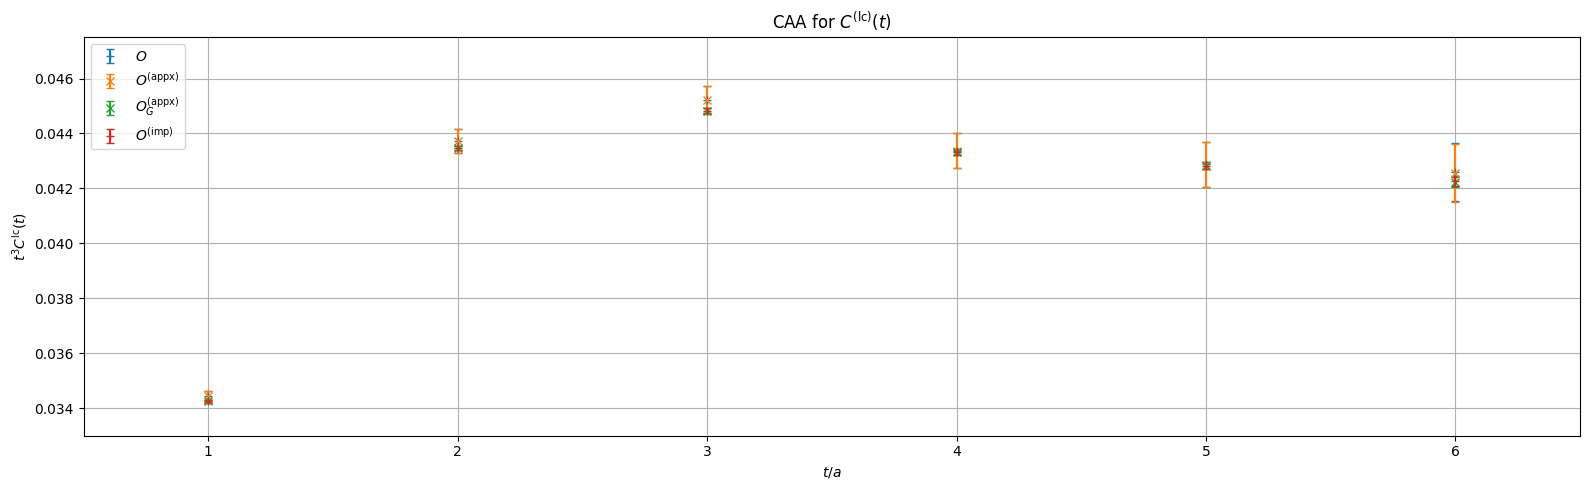

In [28]:
fig, ax = plt.subplots(ncols=1, figsize=(16,5))

add_CAA_to_plot(ax, tag="9a/exact_exact/Gi_Gi_lc", appx_tag="9a/exact_sloppy/Gi_Gi_lc", appx_G_tag="9a/CAA_sloppy/Gi_Gi_lc", CAA_tag="9a/CAA/Gi_Gi_lc")

ax.set_xlim(0.5,6.5)
ax.set_ylim(0.033, 0.0475)

ax.set_title(r"CAA for $C^\text{(lc)}(t)$")
ax.grid()
ax.legend()

plt.tight_layout()
plt.plot()

### $Z(t) = C^{(\text{lc})}/C^{(\text{ll})}$
Finally, we are intereted in computing an improved estimate for the ratio $Z(t) = C^{(\text{lc})}/C^{(\text{ll})}$.

To this end, we compare three different combinations of lc and ll estimators to assess which provides the most precise result. The underlying idea is that the statistical error of a ratio is suppressed when numerator and denominator exhibit similar fluctuations. The tested strategies are:

1. **Baseline**: Use `exact_exact` estimates for both $C^{(\text{lc})}$ and $C^{(\text{ll})}$.

In [35]:
db.combine("9a/exact_exact/Gi_Gi_lc", "9a/exact_exact/Gi_Gi_ll", f=lambda lc,ll: lc/ll, dst_tag="9a/exact_exact/Zt")

STATPY:		162.870454 s: 9a/exact_exact/Zt already in database. Leaf not added.


2. **Full CAA**: Use the improved estimators from the full CAA procedure for both $C^{(\text{lc})}$ and $C^{(\text{ll})}$,  incorporating all available point sources.

In [30]:
db.combine("9a/CAA/Gi_Gi_lc", "9a/CAA/Gi_Gi_ll", f=lambda lc,ll: lc/ll, dst_tag="9a/CAA/Zt")

3. **Matched-source CAA**: Compute a CAA estimate of $C^{(\text{lc})}$ that relies only on `lc` data, and a CAA estimate of $C^{(\text{ll})}$ constructed from only `ll` data on the same set of source positions as `lc`.

In [31]:
apply_CAA(tag="9a/exact_exact/Gi_Gi_lc", appx_tag="9a/exact_sloppy/Gi_Gi_lc", appx_G_tag="9a/sloppy_sloppy/Gi_Gi_lc", CAA_label="CAA_exact_sloppy")
apply_CAA(tag="9a/exact_exact/Gi_Gi_ll", appx_tag="9a/exact_sloppy/Gi_Gi_ll", appx_G_tag="9a/sloppy_sloppy/Gi_Gi_ll/matched", CAA_label="CAA_matched")
db.combine("9a/CAA_exact_sloppy/Gi_Gi_lc", "9a/CAA_matched/Gi_Gi_ll", f=lambda lc,ll: lc/ll, dst_tag="9a/CAA_matched/Zt")

[]

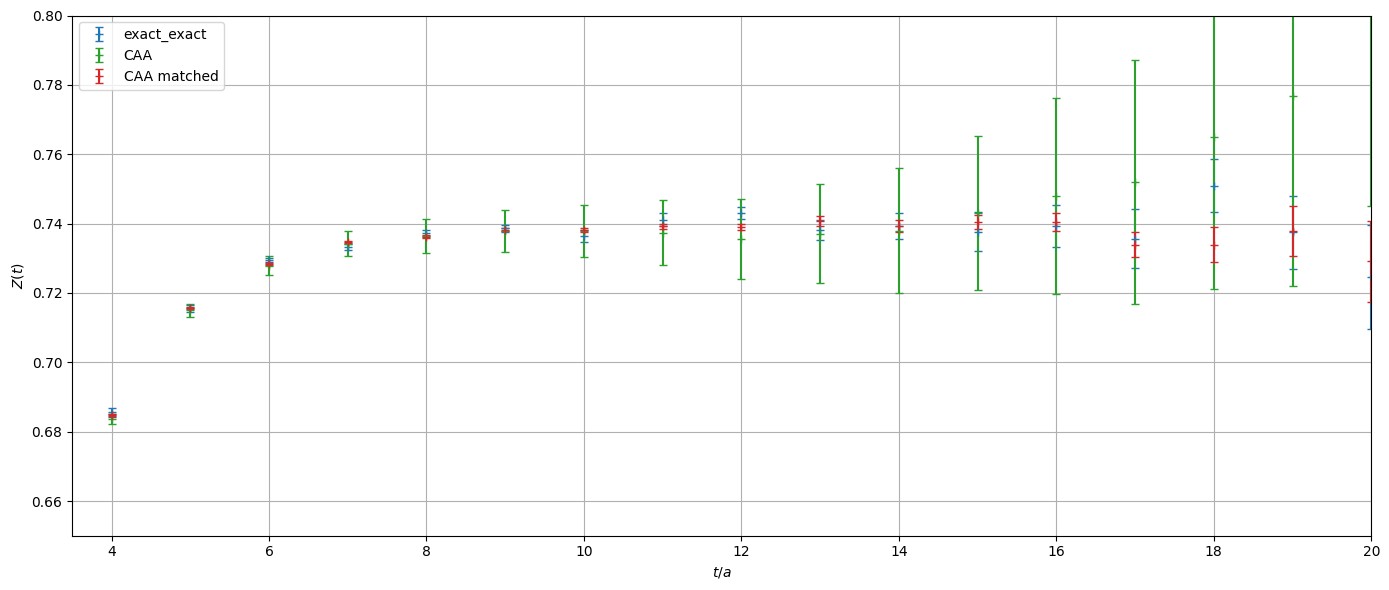

In [43]:
Zt_exact_exact = db.database["9a/exact_exact/Zt"].mean; Zt_exact_exact_var = db.jackknife_variance("9a/exact_exact/Zt", binsize=1)
Zt_CAA = db.database["9a/CAA/Zt"].mean; Zt_CAA_var = db.jackknife_variance("9a/CAA/Zt", binsize=1)
Zt_CAA_matched = db.database["9a/CAA_matched/Zt"].mean; Zt_CAA_matched_var = db.jackknife_variance("9a/CAA_matched/Zt", binsize=1)
ts = np.arange(len(Zt_exact_exact))

fig, ax = plt.subplots(figsize=(14,6))

ax.errorbar(ts, Zt_exact_exact, Zt_exact_exact_var**.5, capsize=3, marker="+", linestyle="", label="exact_exact")
ax.errorbar(ts, Zt_CAA, Zt_CAA_var**.5, capsize=3, marker="+", linestyle="", label="CAA", color="C2")
ax.errorbar(ts, Zt_CAA_matched, Zt_CAA_matched_var**.5, capsize=3, marker="+", linestyle="", label="CAA matched", color="C3")

ax.set_ylabel(r"$Z(t)$")
ax.set_xlabel(r"$t/a$")

ax.set_ylim(0.65, 0.8)
ax.set_xlim(3.5,20)

ax.grid()
ax.legend()
plt.tight_layout()
plt.plot()

Relative to the `exact_exact` baseline, the **full CAA** estimate performs significantly worse due to reduced correlations between numerator and denominator, which leads to larger statistical uncertainty in the ratio. 

In contrast, the **matched-source CAA** approach, where both $C^{(\text{lc})}$ and $C^{(\text{ll})}$ are constructed from the same set of source positions, exploits strong correlations between the two and achieves smaller errors than the baseline. This highlights the importance of matching source positions when forming ratios of correlated observables.

In [46]:
print(Zt_exact_exact_var**.5 / Zt_CAA_var**.5)

[2.13968975e+00 2.61351587e+00 1.94084714e+00 1.34212694e+00
 9.10345709e-01 4.82648743e-01 3.07603031e-01 2.24604684e-01
 1.82859740e-01 1.69736933e-01 2.31142145e-01 1.98437749e-01
 1.58072310e-01 2.02704445e-01 2.09056923e-01 2.50488911e-01
 2.14522781e-01 2.42331402e-01 1.75638393e-01 1.92033845e-01
 2.11919017e-01 3.46808772e-01 1.54186089e-01 7.94270323e-02
 7.91561396e-02 1.61581292e-01 8.04931733e-02 1.43971072e-01
 1.59898557e-01 1.47095792e-02 5.62570339e-03 7.47931136e-03
 6.68967306e-03 8.98170092e-03 1.89970055e-02 4.21729300e-02
 9.43208293e-02 3.09931256e+01 1.42772995e+01 2.16404354e+00
 1.80503259e-01 1.75151856e-01 2.08769551e-01 1.70170040e-01
 1.85292693e-01 1.83709044e-01 2.17137457e-01 2.38939331e-01
 3.30842320e-01 2.89578632e-01 3.53760149e-01 3.51052498e-01
 2.94105100e-01 2.19288838e-01 2.46449784e-01 3.44718006e-01
 2.94853982e-01 2.74525798e-01 3.10943473e-01 3.95841086e-01
 6.89273433e-01 1.22623191e+00 1.97676914e+00 2.60106801e+00]


In [47]:
print(Zt_exact_exact_var**.5 / Zt_CAA_matched_var**.5)

[2.64934609e+00 3.10212003e+00 2.57835891e+00 2.28707358e+00
 2.83866509e+00 2.75626621e+00 2.68487306e+00 2.16415797e+00
 2.02243821e+00 2.18485320e+00 2.91276379e+00 2.72209349e+00
 1.99694066e+00 2.20777048e+00 2.20650312e+00 2.69350359e+00
 2.31206648e+00 2.35220239e+00 1.53007428e+00 1.46441318e+00
 1.27669089e+00 1.34998062e+00 2.33563890e-01 4.17560384e-04
 2.21367384e-02 1.01724338e+00 5.19191221e-01 3.52574289e+00
 9.33629778e+00 1.69502700e+00 8.12276850e-01 5.95197232e-01
 8.84812543e-02 5.48495007e-02 6.84329215e-02 9.06873988e-04
 3.98167061e-01 1.15733520e+02 1.74667811e+02 2.60087514e+01
 2.40368047e+00 2.96516895e+00 3.28195469e+00 2.27451840e+00
 1.95448213e+00 1.80486132e+00 1.88616437e+00 1.93534816e+00
 2.92484560e+00 2.61776009e+00 3.00124883e+00 3.36489706e+00
 3.00341831e+00 1.93291766e+00 2.13909768e+00 3.15841945e+00
 2.87715139e+00 2.48203011e+00 2.47109516e+00 2.23147771e+00
 2.19879110e+00 2.43019870e+00 2.76552440e+00 2.73462479e+00]
